In [1]:
# conda install keras-tuner
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import seaborn as sns
sns.set()
from collections import Counter
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, classification_report
# import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow.keras import losses
# from tensorflow.keras.constraints import maxnorm
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import *
import keras_tuner as kt

2022-12-03 12:41:15.361939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Bitcoin

In [3]:
regs = pd.read_csv("../Data/train_btc_selected_features.csv")
btc = pd.read_csv("../Data/btc_Data.csv")
for i in range(len(btc['Date'])):
    btc['Date'][i]  =  datetime.strptime(btc['Date'][i], '%Y/%m/%d')

btc = btc.set_index("Date")

/tmp/ipykernel_205113/2421463472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['Date'][i]  =  datetime.strptime(btc['Date'][i], '%Y/%m/%d')


In [4]:
btcData = btc[regs.columns]

In [5]:
btcData['returns'] = btcData['priceUSD'].pct_change()

/tmp/ipykernel_205113/751970969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btcData['returns'] = btcData['priceUSD'].pct_change()


In [6]:
Data = btcData.drop(columns=['priceUSD'])
Data = Data[1:]

In [7]:
Data 

,difficulty14mom,difficulty30mom,difficulty3rsi,difficulty90mom,difficulty90sma,hashrate90std,hashrate90var,median_transaction_fee90rocUSD,median_transaction_feeUSD,mining_profitability,...,price90wmaUSD,sentinusd90emaUSD,sentinusdUSD,top100cap,top100cap14trx,top100cap30rsi,top100cap30trx,top100cap90rsi,top100cap90trx,returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.055500e+01,8.384389e+08,1.757449e+17,0.000,0.000,401834.0000,...,0.0,0,2.612000e+03,25.782,0.139,71.191,0.308,79.756,0.550,0.466667
2010-07-19,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.248600e+01,8.819952e+08,1.944789e+17,0.000,0.000,481473.0000,...,0.0,0,4.047000e+03,25.685,0.123,68.863,0.300,78.999,0.547,0.183196
2010-07-20,1.584060e+02,1.641620e+02,100.00,1.735570e+02,2.441400e+01,9.280542e+08,2.153212e+17,0.000,0.000,431831.0000,...,0.0,0,2.341000e+03,25.602,0.107,66.923,0.292,78.355,0.544,-0.088475
2010-07-21,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.630400e+01,9.761949e+08,2.382391e+17,0.000,0.000,460783.0000,...,0.0,0,2.122000e+03,25.638,0.092,67.334,0.284,78.431,0.541,-0.020434
2010-07-22,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.819400e+01,1.019474e+09,2.598318e+17,0.000,0.000,334641.0000,...,0.0,0,2.570000e+03,25.604,0.078,66.526,0.275,78.166,0.537,-0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.384949e+13,4.612156e+19,5.317997e+38,165.380,0.818,0.0577,...,18820.0,28544682257,6.114577e+09,15.236,-0.080,40.118,-0.042,45.140,0.001,0.008075
2022-11-25,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.394503e+13,4.542600e+19,5.158804e+38,214.464,0.812,0.0541,...,18759.0,28076113671,7.224812e+09,15.231,-0.075,39.880,-0.043,45.047,0.001,-0.006565
2022-11-26,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.404058e+13,4.624135e+19,5.345655e+38,255.004,0.809,0.0571,...,18701.0,27566714445,4.898449e+09,15.233,-0.070,40.069,-0.043,45.106,0.001,0.004001


In [8]:
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = btcData['priceUSD'].shift(-30)[1:] # 反之亦然

In [9]:
X.head(3)

,difficulty14mom,difficulty30mom,difficulty3rsi,difficulty90mom,difficulty90sma,hashrate90std,hashrate90var,median_transaction_fee90rocUSD,median_transaction_feeUSD,mining_profitability,...,price90wmaUSD,sentinusd90emaUSD,sentinusdUSD,top100cap,top100cap14trx,top100cap30rsi,top100cap30trx,top100cap90rsi,top100cap90trx,returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,162.138,164.162,100.0,173.723,20.555,838438881.0,1.757449e+17,0.0,0.0,401834.0,...,0.0,0,2612.0,25.782,0.139,71.191,0.308,79.756,0.550,0.466667
2010-07-19,162.138,164.162,100.0,173.723,22.486,881995244.0,1.944789e+17,0.0,0.0,481473.0,...,0.0,0,4047.0,25.685,0.123,68.863,0.300,78.999,0.547,0.183196
2010-07-20,158.406,164.162,100.0,173.557,24.414,928054231.0,2.153212e+17,0.0,0.0,431831.0,...,0.0,0,2341.0,25.602,0.107,66.923,0.292,78.355,0.544,-0.088475


In [10]:
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

In [11]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


Pipeline(steps=[('mixmax', MinMaxScaler()), ['robust', RobustScaler()]],
         verbose=True)

In [12]:
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)

In [13]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [14]:
# define neural network model
shape=X.shape[1]
def build_model(hp, initializer='normal', activation='relu', NUM_FEATURES=shape):
    # create model
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    model = Sequential()
    model.add(Dense(hp_units1, input_shape=(NUM_FEATURES,), kernel_initializer=initializer, activation=activation))
    model.add(Dense(hp_units2, activation=activation))
    model.add(Dense(hp_units3, activation=activation))
    model.add(Dense(1, activation=activation))
    # Compile model
    adam=keras.optimizers.Adam(lr=lr_schedule(0), amsgrad=True)
    #sgd=keras.optimizers.SGD(learning_rate=0.08, momentum=0.9, nesterov=False)
    model.compile(loss='logcosh', optimizer=adam, metrics=['mae'])
    return model

In [15]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    directory='btc_tune',
    project_name='ANN_TUNE'
)

tuner.search(X_train, Y_train, epochs=5000, validation_data=(X_val, Y_val))

Trial 10 Complete [00h 40m 24s]
val_mae: 6186.25927734375

Best val_mae So Far: 6043.03369140625
Total elapsed time: 05h 07m 26s
INFO:tensorflow:Oracle triggered exit


In [16]:
# Get the best hyperparameters.
best_hp = tuner.get_best_hyperparameters()[0]
# Build the model with the best hp.
regressor = build_model(best_hp)
# Fit with the entire dataset.
X_all = np.concatenate((X_train, X_val))
Y_all = np.concatenate((Y_train, Y_val))


Learning rate:  0.001


In [17]:
# best hyperparameters
best_hp

stop training when val_loss is not increasing

In [18]:
earlyStopping = EarlyStopping(monitor='loss', patience=1000,verbose=1, mode='auto')

In [19]:
regressor.fit(x=X_all, y=Y_all, epochs=5000, use_multiprocessing=True, callbacks=[earlyStopping])

Epoch 1/5000
62/62 [==============================] - 0s 3ms/step - loss: 9364.7988 - mae: 9365.4912
Epoch 2/5000
62/62 [==============================] - 0s 3ms/step - loss: 4964.7461 - mae: 4965.4404
Epoch 3/5000
62/62 [==============================] - 0s 3ms/step - loss: 2720.6814 - mae: 2721.3740
Epoch 4/5000
62/62 [==============================] - 0s 3ms/step - loss: 2518.8757 - mae: 2519.5693
Epoch 5/5000
62/62 [==============================] - 0s 4ms/step - loss: 2443.0657 - mae: 2443.7595
Epoch 6/5000
62/62 [==============================] - 0s 5ms/step - loss: 2346.9160 - mae: 2347.6086
Epoch 7/5000
62/62 [==============================] - 0s 6ms/step - loss: 2291.4868 - mae: 2292.1790
Epoch 8/5000
62/62 [==============================] - 0s 4ms/step - loss: 2220.7705 - mae: 2221.4626
Epoch 9/5000
62/62 [==============================] - 0s 3ms/step - loss: 2196.1194 - mae: 2196.8115
Epoch 10/5000
62/62 [==============================] - 0s 3ms/step - loss: 2164.5876 - mae:

62/62 [==============================] - 0s 2ms/step - loss: 1137.7399 - mae: 1138.4320
Epoch 82/5000
62/62 [==============================] - 0s 2ms/step - loss: 1106.9650 - mae: 1107.6560
Epoch 83/5000
62/62 [==============================] - 0s 2ms/step - loss: 1121.7162 - mae: 1122.4092
Epoch 84/5000
62/62 [==============================] - 0s 2ms/step - loss: 1102.0182 - mae: 1102.7107
Epoch 85/5000
62/62 [==============================] - 0s 2ms/step - loss: 1135.3348 - mae: 1136.0275
Epoch 86/5000
62/62 [==============================] - 0s 2ms/step - loss: 1078.6096 - mae: 1079.3019
Epoch 87/5000
62/62 [==============================] - 0s 2ms/step - loss: 1084.0876 - mae: 1084.7800
Epoch 88/5000
62/62 [==============================] - 0s 2ms/step - loss: 1071.9230 - mae: 1072.6145
Epoch 89/5000
62/62 [==============================] - 0s 3ms/step - loss: 1098.2170 - mae: 1098.9099
Epoch 90/5000
62/62 [==============================] - 0s 3ms/step - loss: 1046.9427 - mae: 1047

62/62 [==============================] - 0s 2ms/step - loss: 776.3445 - mae: 777.0357
Epoch 163/5000
62/62 [==============================] - 0s 3ms/step - loss: 819.7905 - mae: 820.4825
Epoch 164/5000
62/62 [==============================] - 0s 3ms/step - loss: 758.9242 - mae: 759.6158
Epoch 165/5000
62/62 [==============================] - 0s 3ms/step - loss: 808.0382 - mae: 808.7300
Epoch 166/5000
62/62 [==============================] - 0s 2ms/step - loss: 750.4822 - mae: 751.1747
Epoch 167/5000
62/62 [==============================] - 0s 3ms/step - loss: 774.8245 - mae: 775.5174
Epoch 168/5000
62/62 [==============================] - 0s 2ms/step - loss: 752.9197 - mae: 753.6124
Epoch 169/5000
62/62 [==============================] - 0s 3ms/step - loss: 773.0764 - mae: 773.7682
Epoch 170/5000
62/62 [==============================] - 0s 2ms/step - loss: 737.0519 - mae: 737.7440
Epoch 171/5000
62/62 [==============================] - 0s 2ms/step - loss: 778.7786 - mae: 779.4708
Epoch

62/62 [==============================] - 0s 2ms/step - loss: 635.5292 - mae: 636.2211
Epoch 244/5000
62/62 [==============================] - 0s 4ms/step - loss: 625.2349 - mae: 625.9257
Epoch 245/5000
62/62 [==============================] - 0s 2ms/step - loss: 629.8207 - mae: 630.5118
Epoch 246/5000
62/62 [==============================] - 0s 3ms/step - loss: 616.3894 - mae: 617.0804
Epoch 247/5000
62/62 [==============================] - 0s 2ms/step - loss: 620.3281 - mae: 621.0197
Epoch 248/5000
62/62 [==============================] - 0s 4ms/step - loss: 666.3889 - mae: 667.0808
Epoch 249/5000
62/62 [==============================] - 0s 3ms/step - loss: 615.0251 - mae: 615.7171
Epoch 250/5000
62/62 [==============================] - 0s 3ms/step - loss: 633.5535 - mae: 634.2446
Epoch 251/5000
62/62 [==============================] - 0s 3ms/step - loss: 620.0923 - mae: 620.7847
Epoch 252/5000
62/62 [==============================] - 0s 2ms/step - loss: 631.3593 - mae: 632.0502
Epoch

62/62 [==============================] - 0s 3ms/step - loss: 610.8101 - mae: 611.5012
Epoch 325/5000
62/62 [==============================] - 0s 3ms/step - loss: 593.8706 - mae: 594.5619
Epoch 326/5000
62/62 [==============================] - 0s 2ms/step - loss: 550.0043 - mae: 550.6948
Epoch 327/5000
62/62 [==============================] - 0s 3ms/step - loss: 585.2076 - mae: 585.8987
Epoch 328/5000
62/62 [==============================] - 0s 3ms/step - loss: 557.8773 - mae: 558.5683
Epoch 329/5000
62/62 [==============================] - 0s 2ms/step - loss: 567.0355 - mae: 567.7266
Epoch 330/5000
62/62 [==============================] - 0s 2ms/step - loss: 545.4635 - mae: 546.1547
Epoch 331/5000
62/62 [==============================] - 0s 3ms/step - loss: 558.8514 - mae: 559.5432
Epoch 332/5000
62/62 [==============================] - 0s 3ms/step - loss: 565.8434 - mae: 566.5345
Epoch 333/5000
62/62 [==============================] - 0s 4ms/step - loss: 570.5858 - mae: 571.2773
Epoch

62/62 [==============================] - 0s 4ms/step - loss: 496.5856 - mae: 497.2764
Epoch 406/5000
62/62 [==============================] - 0s 4ms/step - loss: 524.1228 - mae: 524.8129
Epoch 407/5000
62/62 [==============================] - 1s 11ms/step - loss: 508.6674 - mae: 509.3592
Epoch 408/5000
62/62 [==============================] - 0s 2ms/step - loss: 494.8496 - mae: 495.5400
Epoch 409/5000
62/62 [==============================] - 0s 2ms/step - loss: 497.6863 - mae: 498.3779
Epoch 410/5000
62/62 [==============================] - 0s 3ms/step - loss: 499.5201 - mae: 500.2117
Epoch 411/5000
62/62 [==============================] - 0s 3ms/step - loss: 525.6529 - mae: 526.3441
Epoch 412/5000
62/62 [==============================] - 0s 3ms/step - loss: 534.8563 - mae: 535.5477
Epoch 413/5000
62/62 [==============================] - 0s 3ms/step - loss: 493.8914 - mae: 494.5815
Epoch 414/5000
62/62 [==============================] - 0s 5ms/step - loss: 510.7006 - mae: 511.3919
Epoc

62/62 [==============================] - 0s 3ms/step - loss: 490.4293 - mae: 491.1207
Epoch 487/5000
62/62 [==============================] - 0s 3ms/step - loss: 486.7343 - mae: 487.4254
Epoch 488/5000
62/62 [==============================] - 0s 3ms/step - loss: 467.5898 - mae: 468.2799
Epoch 489/5000
62/62 [==============================] - 0s 2ms/step - loss: 479.5326 - mae: 480.2238
Epoch 490/5000
62/62 [==============================] - 0s 3ms/step - loss: 516.8507 - mae: 517.5413
Epoch 491/5000
62/62 [==============================] - 0s 3ms/step - loss: 501.0148 - mae: 501.7052
Epoch 492/5000
62/62 [==============================] - 0s 3ms/step - loss: 482.1740 - mae: 482.8645
Epoch 493/5000
62/62 [==============================] - 0s 5ms/step - loss: 465.4042 - mae: 466.0941
Epoch 494/5000
62/62 [==============================] - 0s 7ms/step - loss: 483.2798 - mae: 483.9709
Epoch 495/5000
62/62 [==============================] - 0s 4ms/step - loss: 464.5893 - mae: 465.2784
Epoch

62/62 [==============================] - 0s 3ms/step - loss: 465.5110 - mae: 466.2006
Epoch 568/5000
62/62 [==============================] - 0s 3ms/step - loss: 445.2095 - mae: 445.9011
Epoch 569/5000
62/62 [==============================] - 0s 3ms/step - loss: 439.9082 - mae: 440.5980
Epoch 570/5000
62/62 [==============================] - 0s 2ms/step - loss: 455.8369 - mae: 456.5269
Epoch 571/5000
62/62 [==============================] - 0s 2ms/step - loss: 436.2080 - mae: 436.8994
Epoch 572/5000
62/62 [==============================] - 0s 2ms/step - loss: 448.2675 - mae: 448.9562
Epoch 573/5000
62/62 [==============================] - 0s 2ms/step - loss: 462.2018 - mae: 462.8914
Epoch 574/5000
62/62 [==============================] - 0s 2ms/step - loss: 444.4784 - mae: 445.1693
Epoch 575/5000
62/62 [==============================] - 0s 2ms/step - loss: 465.1217 - mae: 465.8126
Epoch 576/5000
62/62 [==============================] - 0s 2ms/step - loss: 434.6546 - mae: 435.3449
Epoch

62/62 [==============================] - 0s 2ms/step - loss: 447.5749 - mae: 448.2643
Epoch 649/5000
62/62 [==============================] - 0s 2ms/step - loss: 425.7946 - mae: 426.4844
Epoch 650/5000
62/62 [==============================] - 0s 3ms/step - loss: 446.3307 - mae: 447.0207
Epoch 651/5000
62/62 [==============================] - 0s 3ms/step - loss: 456.1879 - mae: 456.8778
Epoch 652/5000
62/62 [==============================] - 0s 3ms/step - loss: 465.7096 - mae: 466.3988
Epoch 653/5000
62/62 [==============================] - 0s 3ms/step - loss: 422.5965 - mae: 423.2865
Epoch 654/5000
62/62 [==============================] - 0s 3ms/step - loss: 429.3353 - mae: 430.0239
Epoch 655/5000
62/62 [==============================] - 0s 2ms/step - loss: 401.6404 - mae: 402.3316
Epoch 656/5000
62/62 [==============================] - 0s 2ms/step - loss: 464.9213 - mae: 465.6119
Epoch 657/5000
62/62 [==============================] - 0s 4ms/step - loss: 424.0266 - mae: 424.7167
Epoch

62/62 [==============================] - 0s 2ms/step - loss: 384.5104 - mae: 385.1982
Epoch 730/5000
62/62 [==============================] - 0s 3ms/step - loss: 431.2701 - mae: 431.9579
Epoch 731/5000
62/62 [==============================] - 0s 5ms/step - loss: 427.7387 - mae: 428.4286
Epoch 732/5000
62/62 [==============================] - 0s 3ms/step - loss: 399.6486 - mae: 400.3389
Epoch 733/5000
62/62 [==============================] - 0s 3ms/step - loss: 467.4527 - mae: 468.1422
Epoch 734/5000
62/62 [==============================] - 0s 3ms/step - loss: 399.2880 - mae: 399.9770
Epoch 735/5000
62/62 [==============================] - 0s 3ms/step - loss: 447.2048 - mae: 447.8950
Epoch 736/5000
62/62 [==============================] - 0s 2ms/step - loss: 425.7133 - mae: 426.4026
Epoch 737/5000
62/62 [==============================] - 0s 3ms/step - loss: 423.0378 - mae: 423.7256
Epoch 738/5000
62/62 [==============================] - 0s 3ms/step - loss: 428.8120 - mae: 429.5013
Epoch

62/62 [==============================] - 0s 4ms/step - loss: 376.6279 - mae: 377.3155
Epoch 811/5000
62/62 [==============================] - 0s 3ms/step - loss: 367.9929 - mae: 368.6814
Epoch 812/5000
62/62 [==============================] - 0s 3ms/step - loss: 383.1353 - mae: 383.8258
Epoch 813/5000
62/62 [==============================] - 0s 4ms/step - loss: 424.1170 - mae: 424.8053
Epoch 814/5000
62/62 [==============================] - 0s 3ms/step - loss: 407.0572 - mae: 407.7452
Epoch 815/5000
62/62 [==============================] - 0s 4ms/step - loss: 380.2527 - mae: 380.9396
Epoch 816/5000
62/62 [==============================] - 0s 3ms/step - loss: 395.2836 - mae: 395.9717
Epoch 817/5000
62/62 [==============================] - 0s 4ms/step - loss: 399.2685 - mae: 399.9580
Epoch 818/5000
62/62 [==============================] - 0s 3ms/step - loss: 381.7742 - mae: 382.4641
Epoch 819/5000
62/62 [==============================] - 0s 5ms/step - loss: 410.3191 - mae: 411.0089
Epoch

62/62 [==============================] - 0s 3ms/step - loss: 401.8184 - mae: 402.5075
Epoch 892/5000
62/62 [==============================] - 0s 3ms/step - loss: 370.4457 - mae: 371.1336
Epoch 893/5000
62/62 [==============================] - 0s 2ms/step - loss: 369.3448 - mae: 370.0334
Epoch 894/5000
62/62 [==============================] - 0s 2ms/step - loss: 367.0783 - mae: 367.7666
Epoch 895/5000
62/62 [==============================] - 0s 2ms/step - loss: 367.1385 - mae: 367.8277
Epoch 896/5000
62/62 [==============================] - 0s 2ms/step - loss: 387.5091 - mae: 388.1972
Epoch 897/5000
62/62 [==============================] - 0s 2ms/step - loss: 381.5186 - mae: 382.2083
Epoch 898/5000
62/62 [==============================] - 0s 2ms/step - loss: 357.2213 - mae: 357.9097
Epoch 899/5000
62/62 [==============================] - 0s 4ms/step - loss: 430.0310 - mae: 430.7197
Epoch 900/5000
62/62 [==============================] - 0s 4ms/step - loss: 393.5433 - mae: 394.2329
Epoch

62/62 [==============================] - 0s 3ms/step - loss: 357.6988 - mae: 358.3854
Epoch 973/5000
62/62 [==============================] - 0s 2ms/step - loss: 343.4885 - mae: 344.1755
Epoch 974/5000
62/62 [==============================] - 0s 3ms/step - loss: 346.9499 - mae: 347.6386
Epoch 975/5000
62/62 [==============================] - 0s 2ms/step - loss: 348.1531 - mae: 348.8433
Epoch 976/5000
62/62 [==============================] - 0s 4ms/step - loss: 370.2639 - mae: 370.9539
Epoch 977/5000
62/62 [==============================] - 0s 2ms/step - loss: 374.9997 - mae: 375.6871
Epoch 978/5000
62/62 [==============================] - 0s 2ms/step - loss: 376.2611 - mae: 376.9511
Epoch 979/5000
62/62 [==============================] - 0s 2ms/step - loss: 360.2147 - mae: 360.9039
Epoch 980/5000
62/62 [==============================] - 0s 2ms/step - loss: 349.3989 - mae: 350.0880
Epoch 981/5000
62/62 [==============================] - 0s 3ms/step - loss: 341.5721 - mae: 342.2613
Epoch

62/62 [==============================] - 0s 3ms/step - loss: 357.7711 - mae: 358.4586
Epoch 1053/5000
62/62 [==============================] - 0s 3ms/step - loss: 374.8958 - mae: 375.5854
Epoch 1054/5000
62/62 [==============================] - 0s 3ms/step - loss: 365.8210 - mae: 366.5085
Epoch 1055/5000
62/62 [==============================] - 0s 3ms/step - loss: 353.7060 - mae: 354.3943
Epoch 1056/5000
62/62 [==============================] - 0s 3ms/step - loss: 358.9695 - mae: 359.6588
Epoch 1057/5000
62/62 [==============================] - 0s 4ms/step - loss: 350.3969 - mae: 351.0865
Epoch 1058/5000
62/62 [==============================] - 0s 3ms/step - loss: 349.9735 - mae: 350.6602
Epoch 1059/5000
62/62 [==============================] - 0s 2ms/step - loss: 349.5119 - mae: 350.2001
Epoch 1060/5000
62/62 [==============================] - 0s 2ms/step - loss: 329.3030 - mae: 329.9912
Epoch 1061/5000
62/62 [==============================] - 0s 2ms/step - loss: 371.7969 - mae: 372.4

62/62 [==============================] - 0s 5ms/step - loss: 372.9117 - mae: 373.6020
Epoch 1133/5000
62/62 [==============================] - 0s 5ms/step - loss: 349.9318 - mae: 350.6216
Epoch 1134/5000
62/62 [==============================] - 1s 8ms/step - loss: 334.6909 - mae: 335.3786
Epoch 1135/5000
62/62 [==============================] - 0s 5ms/step - loss: 326.0936 - mae: 326.7807
Epoch 1136/5000
62/62 [==============================] - 0s 3ms/step - loss: 322.5496 - mae: 323.2393
Epoch 1137/5000
62/62 [==============================] - 0s 2ms/step - loss: 327.3230 - mae: 328.0115
Epoch 1138/5000
62/62 [==============================] - 0s 3ms/step - loss: 383.6666 - mae: 384.3557
Epoch 1139/5000
62/62 [==============================] - 0s 3ms/step - loss: 335.0952 - mae: 335.7842
Epoch 1140/5000
62/62 [==============================] - 0s 3ms/step - loss: 329.9377 - mae: 330.6248
Epoch 1141/5000
62/62 [==============================] - 0s 2ms/step - loss: 327.3683 - mae: 328.0

62/62 [==============================] - 0s 3ms/step - loss: 330.3936 - mae: 331.0812
Epoch 1213/5000
62/62 [==============================] - 0s 2ms/step - loss: 328.6510 - mae: 329.3396
Epoch 1214/5000
62/62 [==============================] - 0s 3ms/step - loss: 354.7004 - mae: 355.3887
Epoch 1215/5000
62/62 [==============================] - 0s 3ms/step - loss: 357.5659 - mae: 358.2552
Epoch 1216/5000
62/62 [==============================] - 0s 4ms/step - loss: 322.2458 - mae: 322.9328
Epoch 1217/5000
62/62 [==============================] - 0s 6ms/step - loss: 322.9476 - mae: 323.6381
Epoch 1218/5000
62/62 [==============================] - 0s 3ms/step - loss: 329.9582 - mae: 330.6455
Epoch 1219/5000
62/62 [==============================] - 0s 2ms/step - loss: 323.0648 - mae: 323.7529
Epoch 1220/5000
62/62 [==============================] - 0s 4ms/step - loss: 345.5946 - mae: 346.2830
Epoch 1221/5000
62/62 [==============================] - 0s 3ms/step - loss: 316.7164 - mae: 317.4

62/62 [==============================] - 0s 2ms/step - loss: 316.8846 - mae: 317.5728
Epoch 1293/5000
62/62 [==============================] - 0s 3ms/step - loss: 304.5565 - mae: 305.2443
Epoch 1294/5000
62/62 [==============================] - 0s 2ms/step - loss: 320.2101 - mae: 320.8988
Epoch 1295/5000
62/62 [==============================] - 0s 2ms/step - loss: 335.1596 - mae: 335.8469
Epoch 1296/5000
62/62 [==============================] - 0s 3ms/step - loss: 345.3051 - mae: 345.9926
Epoch 1297/5000
62/62 [==============================] - 0s 3ms/step - loss: 368.5465 - mae: 369.2356
Epoch 1298/5000
62/62 [==============================] - 0s 4ms/step - loss: 324.7093 - mae: 325.3966
Epoch 1299/5000
62/62 [==============================] - 0s 4ms/step - loss: 326.1895 - mae: 326.8795
Epoch 1300/5000
62/62 [==============================] - 0s 3ms/step - loss: 321.0877 - mae: 321.7765
Epoch 1301/5000
62/62 [==============================] - 0s 4ms/step - loss: 312.7591 - mae: 313.4

62/62 [==============================] - 0s 2ms/step - loss: 309.9666 - mae: 310.6553
Epoch 1373/5000
62/62 [==============================] - 0s 2ms/step - loss: 309.2521 - mae: 309.9394
Epoch 1374/5000
62/62 [==============================] - 0s 2ms/step - loss: 310.4297 - mae: 311.1185
Epoch 1375/5000
62/62 [==============================] - 0s 2ms/step - loss: 322.1238 - mae: 322.8133
Epoch 1376/5000
62/62 [==============================] - 0s 2ms/step - loss: 339.4197 - mae: 340.1077
Epoch 1377/5000
62/62 [==============================] - 0s 2ms/step - loss: 317.4762 - mae: 318.1634
Epoch 1378/5000
62/62 [==============================] - 0s 2ms/step - loss: 311.1237 - mae: 311.8119
Epoch 1379/5000
62/62 [==============================] - 0s 2ms/step - loss: 295.2661 - mae: 295.9542
Epoch 1380/5000
62/62 [==============================] - 0s 3ms/step - loss: 308.5992 - mae: 309.2879
Epoch 1381/5000
62/62 [==============================] - 0s 3ms/step - loss: 292.0412 - mae: 292.7

62/62 [==============================] - 0s 6ms/step - loss: 306.5016 - mae: 307.1892
Epoch 1453/5000
62/62 [==============================] - 0s 4ms/step - loss: 306.5330 - mae: 307.2214
Epoch 1454/5000
62/62 [==============================] - 0s 4ms/step - loss: 286.4096 - mae: 287.0982
Epoch 1455/5000
62/62 [==============================] - 0s 2ms/step - loss: 303.9772 - mae: 304.6655
Epoch 1456/5000
62/62 [==============================] - 0s 2ms/step - loss: 291.7290 - mae: 292.4160
Epoch 1457/5000
62/62 [==============================] - 0s 2ms/step - loss: 300.8023 - mae: 301.4900
Epoch 1458/5000
62/62 [==============================] - 0s 2ms/step - loss: 293.3462 - mae: 294.0350
Epoch 1459/5000
62/62 [==============================] - 0s 3ms/step - loss: 310.9822 - mae: 311.6691
Epoch 1460/5000
62/62 [==============================] - 0s 3ms/step - loss: 276.8070 - mae: 277.4943
Epoch 1461/5000
62/62 [==============================] - 0s 3ms/step - loss: 302.5190 - mae: 303.2

62/62 [==============================] - 0s 3ms/step - loss: 316.3823 - mae: 317.0724
Epoch 1533/5000
62/62 [==============================] - 0s 3ms/step - loss: 292.1485 - mae: 292.8365
Epoch 1534/5000
62/62 [==============================] - 0s 3ms/step - loss: 317.4194 - mae: 318.1085
Epoch 1535/5000
62/62 [==============================] - 0s 2ms/step - loss: 266.3377 - mae: 267.0230
Epoch 1536/5000
62/62 [==============================] - 0s 2ms/step - loss: 278.8899 - mae: 279.5782
Epoch 1537/5000
62/62 [==============================] - 0s 2ms/step - loss: 294.4423 - mae: 295.1306
Epoch 1538/5000
62/62 [==============================] - 0s 2ms/step - loss: 275.2170 - mae: 275.9051
Epoch 1539/5000
62/62 [==============================] - 0s 2ms/step - loss: 275.8510 - mae: 276.5384
Epoch 1540/5000
62/62 [==============================] - 0s 2ms/step - loss: 278.4778 - mae: 279.1649
Epoch 1541/5000
62/62 [==============================] - 0s 2ms/step - loss: 302.1372 - mae: 302.8

62/62 [==============================] - 0s 3ms/step - loss: 297.1500 - mae: 297.8381
Epoch 1613/5000
62/62 [==============================] - 0s 2ms/step - loss: 301.3238 - mae: 302.0114
Epoch 1614/5000
62/62 [==============================] - 0s 3ms/step - loss: 289.9852 - mae: 290.6736
Epoch 1615/5000
62/62 [==============================] - 0s 3ms/step - loss: 342.6956 - mae: 343.3855
Epoch 1616/5000
62/62 [==============================] - 0s 6ms/step - loss: 289.4275 - mae: 290.1160
Epoch 1617/5000
62/62 [==============================] - 1s 9ms/step - loss: 301.7302 - mae: 302.4202
Epoch 1618/5000
62/62 [==============================] - 1s 8ms/step - loss: 285.9241 - mae: 286.6122
Epoch 1619/5000
62/62 [==============================] - 0s 3ms/step - loss: 296.1528 - mae: 296.8407
Epoch 1620/5000
62/62 [==============================] - 0s 2ms/step - loss: 268.2921 - mae: 268.9796
Epoch 1621/5000
62/62 [==============================] - 0s 3ms/step - loss: 271.1192 - mae: 271.8

62/62 [==============================] - 0s 3ms/step - loss: 286.9932 - mae: 287.6815
Epoch 1693/5000
62/62 [==============================] - 0s 2ms/step - loss: 304.9723 - mae: 305.6595
Epoch 1694/5000
62/62 [==============================] - 1s 10ms/step - loss: 271.7090 - mae: 272.3961
Epoch 1695/5000
62/62 [==============================] - 0s 7ms/step - loss: 310.8712 - mae: 311.5588
Epoch 1696/5000
62/62 [==============================] - 0s 5ms/step - loss: 280.7231 - mae: 281.4128
Epoch 1697/5000
62/62 [==============================] - 0s 5ms/step - loss: 280.9941 - mae: 281.6823
Epoch 1698/5000
62/62 [==============================] - 0s 3ms/step - loss: 272.5150 - mae: 273.2051
Epoch 1699/5000
62/62 [==============================] - 0s 3ms/step - loss: 312.1347 - mae: 312.8232
Epoch 1700/5000
62/62 [==============================] - 0s 3ms/step - loss: 318.6843 - mae: 319.3729
Epoch 1701/5000
62/62 [==============================] - 0s 4ms/step - loss: 266.4384 - mae: 267.

62/62 [==============================] - 0s 4ms/step - loss: 259.3938 - mae: 260.0806
Epoch 1773/5000
62/62 [==============================] - 0s 2ms/step - loss: 280.3498 - mae: 281.0366
Epoch 1774/5000
62/62 [==============================] - 0s 3ms/step - loss: 297.5894 - mae: 298.2782
Epoch 1775/5000
62/62 [==============================] - 0s 3ms/step - loss: 262.9380 - mae: 263.6252
Epoch 1776/5000
62/62 [==============================] - 0s 3ms/step - loss: 294.0796 - mae: 294.7682
Epoch 1777/5000
62/62 [==============================] - 0s 3ms/step - loss: 264.2854 - mae: 264.9735
Epoch 1778/5000
62/62 [==============================] - 0s 3ms/step - loss: 280.9155 - mae: 281.6033
Epoch 1779/5000
62/62 [==============================] - 0s 3ms/step - loss: 263.4963 - mae: 264.1840
Epoch 1780/5000
62/62 [==============================] - 0s 2ms/step - loss: 267.5576 - mae: 268.2466
Epoch 1781/5000
62/62 [==============================] - 0s 2ms/step - loss: 311.1957 - mae: 311.8

62/62 [==============================] - 0s 2ms/step - loss: 261.9822 - mae: 262.6682
Epoch 1853/5000
62/62 [==============================] - 0s 3ms/step - loss: 260.6144 - mae: 261.2999
Epoch 1854/5000
62/62 [==============================] - 0s 3ms/step - loss: 245.2694 - mae: 245.9576
Epoch 1855/5000
62/62 [==============================] - 0s 3ms/step - loss: 257.8020 - mae: 258.4907
Epoch 1856/5000
62/62 [==============================] - 0s 7ms/step - loss: 254.6623 - mae: 255.3496
Epoch 1857/5000
62/62 [==============================] - 0s 3ms/step - loss: 253.3067 - mae: 253.9950
Epoch 1858/5000
62/62 [==============================] - 0s 3ms/step - loss: 261.8347 - mae: 262.5210
Epoch 1859/5000
62/62 [==============================] - 0s 3ms/step - loss: 259.1074 - mae: 259.7948
Epoch 1860/5000
62/62 [==============================] - 0s 3ms/step - loss: 261.6324 - mae: 262.3195
Epoch 1861/5000
62/62 [==============================] - 0s 5ms/step - loss: 256.4369 - mae: 257.1

62/62 [==============================] - 0s 3ms/step - loss: 280.6801 - mae: 281.3681
Epoch 1933/5000
62/62 [==============================] - 0s 3ms/step - loss: 287.7020 - mae: 288.3904
Epoch 1934/5000
62/62 [==============================] - 0s 3ms/step - loss: 286.1229 - mae: 286.8106
Epoch 1935/5000
62/62 [==============================] - 0s 3ms/step - loss: 247.1985 - mae: 247.8856
Epoch 1936/5000
62/62 [==============================] - 0s 5ms/step - loss: 256.0022 - mae: 256.6901
Epoch 1937/5000
62/62 [==============================] - 0s 3ms/step - loss: 283.5992 - mae: 284.2874
Epoch 1938/5000
62/62 [==============================] - 0s 3ms/step - loss: 304.9138 - mae: 305.6012
Epoch 1939/5000
62/62 [==============================] - 0s 5ms/step - loss: 263.6197 - mae: 264.3061
Epoch 1940/5000
62/62 [==============================] - 0s 3ms/step - loss: 279.9660 - mae: 280.6544
Epoch 1941/5000
62/62 [==============================] - 0s 5ms/step - loss: 259.1903 - mae: 259.8

62/62 [==============================] - 0s 2ms/step - loss: 262.5630 - mae: 263.2517
Epoch 2013/5000
62/62 [==============================] - 0s 2ms/step - loss: 302.4073 - mae: 303.0930
Epoch 2014/5000
62/62 [==============================] - 0s 2ms/step - loss: 247.3278 - mae: 248.0156
Epoch 2015/5000
62/62 [==============================] - 0s 2ms/step - loss: 261.0587 - mae: 261.7453
Epoch 2016/5000
62/62 [==============================] - 0s 2ms/step - loss: 242.3271 - mae: 243.0134
Epoch 2017/5000
62/62 [==============================] - 0s 3ms/step - loss: 234.0053 - mae: 234.6922
Epoch 2018/5000
62/62 [==============================] - 0s 3ms/step - loss: 244.2140 - mae: 244.9018
Epoch 2019/5000
62/62 [==============================] - 0s 4ms/step - loss: 249.2098 - mae: 249.8973
Epoch 2020/5000
62/62 [==============================] - 0s 2ms/step - loss: 313.3649 - mae: 314.0540
Epoch 2021/5000
62/62 [==============================] - 0s 3ms/step - loss: 265.4859 - mae: 266.1

62/62 [==============================] - 0s 3ms/step - loss: 252.1959 - mae: 252.8836
Epoch 2093/5000
62/62 [==============================] - 0s 2ms/step - loss: 252.1394 - mae: 252.8276
Epoch 2094/5000
62/62 [==============================] - 0s 3ms/step - loss: 276.4829 - mae: 277.1709
Epoch 2095/5000
62/62 [==============================] - 0s 3ms/step - loss: 255.4256 - mae: 256.1135
Epoch 2096/5000
62/62 [==============================] - 0s 3ms/step - loss: 237.2267 - mae: 237.9146
Epoch 2097/5000
62/62 [==============================] - 0s 5ms/step - loss: 236.3663 - mae: 237.0527
Epoch 2098/5000
62/62 [==============================] - 0s 5ms/step - loss: 234.6535 - mae: 235.3407
Epoch 2099/5000
62/62 [==============================] - 0s 5ms/step - loss: 267.4806 - mae: 268.1669
Epoch 2100/5000
62/62 [==============================] - 0s 3ms/step - loss: 255.3401 - mae: 256.0273
Epoch 2101/5000
62/62 [==============================] - 0s 3ms/step - loss: 244.9699 - mae: 245.6

62/62 [==============================] - 0s 6ms/step - loss: 256.2618 - mae: 256.9515
Epoch 2173/5000
62/62 [==============================] - 0s 4ms/step - loss: 266.5593 - mae: 267.2479
Epoch 2174/5000
62/62 [==============================] - 0s 3ms/step - loss: 249.9938 - mae: 250.6818
Epoch 2175/5000
62/62 [==============================] - 0s 3ms/step - loss: 250.5542 - mae: 251.2390
Epoch 2176/5000
62/62 [==============================] - 0s 3ms/step - loss: 235.8260 - mae: 236.5122
Epoch 2177/5000
62/62 [==============================] - 0s 4ms/step - loss: 240.5558 - mae: 241.2444
Epoch 2178/5000
62/62 [==============================] - 0s 3ms/step - loss: 267.5188 - mae: 268.2063
Epoch 2179/5000
62/62 [==============================] - 0s 4ms/step - loss: 267.8524 - mae: 268.5399
Epoch 2180/5000
62/62 [==============================] - 0s 3ms/step - loss: 264.8414 - mae: 265.5281
Epoch 2181/5000
62/62 [==============================] - 0s 3ms/step - loss: 251.7940 - mae: 252.4

62/62 [==============================] - 0s 3ms/step - loss: 233.8122 - mae: 234.4988
Epoch 2253/5000
62/62 [==============================] - 0s 2ms/step - loss: 263.6885 - mae: 264.3774
Epoch 2254/5000
62/62 [==============================] - 0s 2ms/step - loss: 250.9799 - mae: 251.6683
Epoch 2255/5000
62/62 [==============================] - 0s 2ms/step - loss: 265.4735 - mae: 266.1642
Epoch 2256/5000
62/62 [==============================] - 0s 3ms/step - loss: 237.0123 - mae: 237.6977
Epoch 2257/5000
62/62 [==============================] - 0s 3ms/step - loss: 270.4943 - mae: 271.1822
Epoch 2258/5000
62/62 [==============================] - 0s 2ms/step - loss: 262.1637 - mae: 262.8511
Epoch 2259/5000
62/62 [==============================] - 0s 2ms/step - loss: 256.6123 - mae: 257.3002
Epoch 2260/5000
62/62 [==============================] - 0s 3ms/step - loss: 265.2259 - mae: 265.9119
Epoch 2261/5000
62/62 [==============================] - 0s 4ms/step - loss: 249.7936 - mae: 250.4

62/62 [==============================] - 0s 3ms/step - loss: 271.9842 - mae: 272.6742
Epoch 2333/5000
62/62 [==============================] - 0s 3ms/step - loss: 243.4018 - mae: 244.0910
Epoch 2334/5000
62/62 [==============================] - 0s 3ms/step - loss: 231.7568 - mae: 232.4441
Epoch 2335/5000
62/62 [==============================] - 0s 2ms/step - loss: 227.9295 - mae: 228.6165
Epoch 2336/5000
62/62 [==============================] - 0s 3ms/step - loss: 252.7347 - mae: 253.4215
Epoch 2337/5000
62/62 [==============================] - 0s 5ms/step - loss: 264.1828 - mae: 264.8702
Epoch 2338/5000
62/62 [==============================] - 0s 3ms/step - loss: 239.7821 - mae: 240.4706
Epoch 2339/5000
62/62 [==============================] - 0s 5ms/step - loss: 258.1247 - mae: 258.8124
Epoch 2340/5000
62/62 [==============================] - 0s 5ms/step - loss: 255.6383 - mae: 256.3234
Epoch 2341/5000
62/62 [==============================] - 0s 3ms/step - loss: 255.8965 - mae: 256.5

62/62 [==============================] - 0s 2ms/step - loss: 257.0470 - mae: 257.7362
Epoch 2413/5000
62/62 [==============================] - 0s 2ms/step - loss: 243.2195 - mae: 243.9072
Epoch 2414/5000
62/62 [==============================] - 0s 2ms/step - loss: 233.0042 - mae: 233.6930
Epoch 2415/5000
62/62 [==============================] - 0s 4ms/step - loss: 243.9077 - mae: 244.5933
Epoch 2416/5000
62/62 [==============================] - 0s 3ms/step - loss: 222.7057 - mae: 223.3918
Epoch 2417/5000
62/62 [==============================] - 0s 3ms/step - loss: 233.6770 - mae: 234.3642
Epoch 2418/5000
62/62 [==============================] - 0s 4ms/step - loss: 222.7655 - mae: 223.4510
Epoch 2419/5000
62/62 [==============================] - 0s 4ms/step - loss: 224.6193 - mae: 225.3052
Epoch 2420/5000
62/62 [==============================] - 0s 3ms/step - loss: 242.4412 - mae: 243.1307
Epoch 2421/5000
62/62 [==============================] - 0s 3ms/step - loss: 284.1112 - mae: 284.7

62/62 [==============================] - 0s 8ms/step - loss: 228.5334 - mae: 229.2197
Epoch 2493/5000
62/62 [==============================] - 0s 7ms/step - loss: 254.1560 - mae: 254.8450
Epoch 2494/5000
62/62 [==============================] - 0s 6ms/step - loss: 224.5674 - mae: 225.2529
Epoch 2495/5000
62/62 [==============================] - 0s 4ms/step - loss: 247.4073 - mae: 248.0929
Epoch 2496/5000
62/62 [==============================] - 0s 3ms/step - loss: 236.2557 - mae: 236.9442
Epoch 2497/5000
62/62 [==============================] - 0s 2ms/step - loss: 226.3387 - mae: 227.0265
Epoch 2498/5000
62/62 [==============================] - 0s 2ms/step - loss: 226.0162 - mae: 226.7028
Epoch 2499/5000
62/62 [==============================] - 0s 3ms/step - loss: 250.5237 - mae: 251.2119
Epoch 2500/5000
62/62 [==============================] - 0s 4ms/step - loss: 254.5705 - mae: 255.2586
Epoch 2501/5000
62/62 [==============================] - 0s 3ms/step - loss: 211.7324 - mae: 212.4

62/62 [==============================] - 0s 3ms/step - loss: 254.2280 - mae: 254.9170
Epoch 2573/5000
62/62 [==============================] - 0s 3ms/step - loss: 227.6426 - mae: 228.3292
Epoch 2574/5000
62/62 [==============================] - 0s 2ms/step - loss: 245.1315 - mae: 245.8200
Epoch 2575/5000
62/62 [==============================] - 0s 4ms/step - loss: 255.4951 - mae: 256.1819
Epoch 2576/5000
62/62 [==============================] - 0s 2ms/step - loss: 234.1753 - mae: 234.8648
Epoch 2577/5000
62/62 [==============================] - 0s 2ms/step - loss: 238.5580 - mae: 239.2446
Epoch 2578/5000
62/62 [==============================] - 0s 2ms/step - loss: 232.9514 - mae: 233.6387
Epoch 2579/5000
62/62 [==============================] - 0s 4ms/step - loss: 222.0681 - mae: 222.7546
Epoch 2580/5000
62/62 [==============================] - 0s 3ms/step - loss: 211.4859 - mae: 212.1734
Epoch 2581/5000
62/62 [==============================] - 0s 2ms/step - loss: 219.5612 - mae: 220.2

62/62 [==============================] - 0s 3ms/step - loss: 236.4175 - mae: 237.1040
Epoch 2653/5000
62/62 [==============================] - 0s 3ms/step - loss: 228.4568 - mae: 229.1428
Epoch 2654/5000
62/62 [==============================] - 0s 2ms/step - loss: 223.1685 - mae: 223.8554
Epoch 2655/5000
62/62 [==============================] - 0s 2ms/step - loss: 226.5543 - mae: 227.2408
Epoch 2656/5000
62/62 [==============================] - 0s 2ms/step - loss: 251.4927 - mae: 252.1821
Epoch 2657/5000
62/62 [==============================] - 0s 2ms/step - loss: 222.9467 - mae: 223.6353
Epoch 2658/5000
62/62 [==============================] - 0s 3ms/step - loss: 216.6936 - mae: 217.3811
Epoch 2659/5000
62/62 [==============================] - 0s 4ms/step - loss: 232.3899 - mae: 233.0773
Epoch 2660/5000
62/62 [==============================] - 0s 3ms/step - loss: 235.0935 - mae: 235.7795
Epoch 2661/5000
62/62 [==============================] - 0s 4ms/step - loss: 237.7651 - mae: 238.4

62/62 [==============================] - 0s 2ms/step - loss: 232.3528 - mae: 233.0399
Epoch 2733/5000
62/62 [==============================] - 0s 2ms/step - loss: 221.6033 - mae: 222.2886
Epoch 2734/5000
62/62 [==============================] - 0s 3ms/step - loss: 217.6574 - mae: 218.3448
Epoch 2735/5000
62/62 [==============================] - 0s 2ms/step - loss: 221.5188 - mae: 222.2044
Epoch 2736/5000
62/62 [==============================] - 0s 3ms/step - loss: 220.9523 - mae: 221.6378
Epoch 2737/5000
62/62 [==============================] - 0s 2ms/step - loss: 221.8347 - mae: 222.5211
Epoch 2738/5000
62/62 [==============================] - 0s 2ms/step - loss: 223.6290 - mae: 224.3157
Epoch 2739/5000
62/62 [==============================] - 0s 2ms/step - loss: 206.0287 - mae: 206.7147
Epoch 2740/5000
62/62 [==============================] - 0s 3ms/step - loss: 199.1356 - mae: 199.8209
Epoch 2741/5000
62/62 [==============================] - 0s 5ms/step - loss: 213.9771 - mae: 214.6

62/62 [==============================] - 0s 6ms/step - loss: 244.7962 - mae: 245.4839
Epoch 2813/5000
62/62 [==============================] - 0s 3ms/step - loss: 231.2752 - mae: 231.9620
Epoch 2814/5000
62/62 [==============================] - 0s 2ms/step - loss: 243.9482 - mae: 244.6363
Epoch 2815/5000
62/62 [==============================] - 0s 4ms/step - loss: 245.5983 - mae: 246.2846
Epoch 2816/5000
62/62 [==============================] - 0s 3ms/step - loss: 237.7162 - mae: 238.4049
Epoch 2817/5000
62/62 [==============================] - 0s 5ms/step - loss: 211.8725 - mae: 212.5596
Epoch 2818/5000
62/62 [==============================] - 0s 4ms/step - loss: 223.7834 - mae: 224.4710
Epoch 2819/5000
62/62 [==============================] - 0s 4ms/step - loss: 236.1810 - mae: 236.8681
Epoch 2820/5000
62/62 [==============================] - 0s 3ms/step - loss: 225.0922 - mae: 225.7803
Epoch 2821/5000
62/62 [==============================] - 0s 3ms/step - loss: 242.6929 - mae: 243.3

62/62 [==============================] - 0s 2ms/step - loss: 220.5082 - mae: 221.1943
Epoch 2893/5000
62/62 [==============================] - 0s 2ms/step - loss: 205.7137 - mae: 206.4006
Epoch 2894/5000
62/62 [==============================] - 0s 2ms/step - loss: 223.8265 - mae: 224.5140
Epoch 2895/5000
62/62 [==============================] - 0s 2ms/step - loss: 205.4197 - mae: 206.1080
Epoch 2896/5000
62/62 [==============================] - 0s 3ms/step - loss: 204.1606 - mae: 204.8468
Epoch 2897/5000
62/62 [==============================] - 0s 2ms/step - loss: 234.1397 - mae: 234.8283
Epoch 2898/5000
62/62 [==============================] - 0s 2ms/step - loss: 242.2679 - mae: 242.9542
Epoch 2899/5000
62/62 [==============================] - 0s 3ms/step - loss: 221.5681 - mae: 222.2540
Epoch 2900/5000
62/62 [==============================] - 0s 2ms/step - loss: 205.4256 - mae: 206.1120
Epoch 2901/5000
62/62 [==============================] - 0s 2ms/step - loss: 232.1717 - mae: 232.8

62/62 [==============================] - 0s 5ms/step - loss: 205.7999 - mae: 206.4863
Epoch 2973/5000
62/62 [==============================] - 0s 3ms/step - loss: 232.1493 - mae: 232.8382
Epoch 2974/5000
62/62 [==============================] - 0s 6ms/step - loss: 218.6122 - mae: 219.2991
Epoch 2975/5000
62/62 [==============================] - 0s 3ms/step - loss: 197.8689 - mae: 198.5565
Epoch 2976/5000
62/62 [==============================] - 0s 3ms/step - loss: 212.7221 - mae: 213.4072
Epoch 2977/5000
62/62 [==============================] - 0s 3ms/step - loss: 203.9059 - mae: 204.5937
Epoch 2978/5000
62/62 [==============================] - 0s 4ms/step - loss: 218.0480 - mae: 218.7341
Epoch 2979/5000
62/62 [==============================] - 0s 2ms/step - loss: 237.1574 - mae: 237.8449
Epoch 2980/5000
62/62 [==============================] - 0s 2ms/step - loss: 252.6797 - mae: 253.3685
Epoch 2981/5000
62/62 [==============================] - 0s 2ms/step - loss: 210.2398 - mae: 210.9

62/62 [==============================] - 0s 3ms/step - loss: 226.1793 - mae: 226.8676
Epoch 3053/5000
62/62 [==============================] - 0s 3ms/step - loss: 208.1689 - mae: 208.8569
Epoch 3054/5000
62/62 [==============================] - 0s 3ms/step - loss: 250.6662 - mae: 251.3549
Epoch 3055/5000
62/62 [==============================] - 0s 3ms/step - loss: 227.3110 - mae: 227.9981
Epoch 3056/5000
62/62 [==============================] - 0s 2ms/step - loss: 204.0925 - mae: 204.7786
Epoch 3057/5000
62/62 [==============================] - 0s 2ms/step - loss: 214.6406 - mae: 215.3277
Epoch 3058/5000
62/62 [==============================] - 0s 2ms/step - loss: 205.5168 - mae: 206.2028
Epoch 3059/5000
62/62 [==============================] - 0s 2ms/step - loss: 230.5485 - mae: 231.2335
Epoch 3060/5000
62/62 [==============================] - 0s 2ms/step - loss: 202.1479 - mae: 202.8332
Epoch 3061/5000
62/62 [==============================] - 0s 4ms/step - loss: 223.1161 - mae: 223.8

62/62 [==============================] - 0s 7ms/step - loss: 197.8264 - mae: 198.5137
Epoch 3133/5000
62/62 [==============================] - 0s 3ms/step - loss: 199.5062 - mae: 200.1931
Epoch 3134/5000
62/62 [==============================] - 0s 3ms/step - loss: 214.2234 - mae: 214.9083
Epoch 3135/5000
62/62 [==============================] - 0s 7ms/step - loss: 249.6653 - mae: 250.3546
Epoch 3136/5000
62/62 [==============================] - 0s 3ms/step - loss: 241.7552 - mae: 242.4432
Epoch 3137/5000
62/62 [==============================] - 0s 4ms/step - loss: 192.7441 - mae: 193.4301
Epoch 3138/5000
62/62 [==============================] - 0s 3ms/step - loss: 203.0773 - mae: 203.7637
Epoch 3139/5000
62/62 [==============================] - 0s 3ms/step - loss: 193.3087 - mae: 193.9948
Epoch 3140/5000
62/62 [==============================] - 0s 2ms/step - loss: 190.9667 - mae: 191.6507
Epoch 3141/5000
62/62 [==============================] - 0s 2ms/step - loss: 218.7470 - mae: 219.4

62/62 [==============================] - 0s 3ms/step - loss: 233.3652 - mae: 234.0523
Epoch 3213/5000
62/62 [==============================] - 0s 3ms/step - loss: 207.6704 - mae: 208.3569
Epoch 3214/5000
62/62 [==============================] - 0s 3ms/step - loss: 214.3550 - mae: 215.0414
Epoch 3215/5000
62/62 [==============================] - 0s 4ms/step - loss: 211.5210 - mae: 212.2088
Epoch 3216/5000
62/62 [==============================] - 0s 3ms/step - loss: 184.5656 - mae: 185.2528
Epoch 3217/5000
62/62 [==============================] - 0s 3ms/step - loss: 210.2566 - mae: 210.9463
Epoch 3218/5000
62/62 [==============================] - 0s 3ms/step - loss: 227.1882 - mae: 227.8753
Epoch 3219/5000
62/62 [==============================] - 0s 3ms/step - loss: 217.9119 - mae: 218.6002
Epoch 3220/5000
62/62 [==============================] - 0s 3ms/step - loss: 205.2705 - mae: 205.9568
Epoch 3221/5000
62/62 [==============================] - 0s 3ms/step - loss: 195.0417 - mae: 195.7

62/62 [==============================] - 0s 5ms/step - loss: 217.5550 - mae: 218.2407
Epoch 3293/5000
62/62 [==============================] - 0s 3ms/step - loss: 227.0528 - mae: 227.7415
Epoch 3294/5000
62/62 [==============================] - 0s 2ms/step - loss: 192.6430 - mae: 193.3317
Epoch 3295/5000
62/62 [==============================] - 0s 2ms/step - loss: 206.5247 - mae: 207.2100
Epoch 3296/5000
62/62 [==============================] - 0s 2ms/step - loss: 188.5590 - mae: 189.2452
Epoch 3297/5000
62/62 [==============================] - 0s 2ms/step - loss: 193.7677 - mae: 194.4539
Epoch 3298/5000
62/62 [==============================] - 0s 2ms/step - loss: 211.3445 - mae: 212.0344
Epoch 3299/5000
62/62 [==============================] - 0s 2ms/step - loss: 211.6755 - mae: 212.3607
Epoch 3300/5000
62/62 [==============================] - 0s 2ms/step - loss: 205.9981 - mae: 206.6859
Epoch 3301/5000
62/62 [==============================] - 0s 3ms/step - loss: 206.7503 - mae: 207.4

62/62 [==============================] - 0s 2ms/step - loss: 199.0932 - mae: 199.7794
Epoch 3373/5000
62/62 [==============================] - 0s 2ms/step - loss: 204.9691 - mae: 205.6549
Epoch 3374/5000
62/62 [==============================] - 0s 2ms/step - loss: 204.6080 - mae: 205.2943
Epoch 3375/5000
62/62 [==============================] - 0s 2ms/step - loss: 197.8548 - mae: 198.5412
Epoch 3376/5000
62/62 [==============================] - 0s 2ms/step - loss: 193.0459 - mae: 193.7332
Epoch 3377/5000
62/62 [==============================] - 0s 2ms/step - loss: 197.0673 - mae: 197.7543
Epoch 3378/5000
62/62 [==============================] - 0s 2ms/step - loss: 207.4318 - mae: 208.1197
Epoch 3379/5000
62/62 [==============================] - 0s 2ms/step - loss: 200.5994 - mae: 201.2855
Epoch 3380/5000
62/62 [==============================] - 0s 2ms/step - loss: 208.1871 - mae: 208.8748
Epoch 3381/5000
62/62 [==============================] - 0s 3ms/step - loss: 192.3660 - mae: 193.0

62/62 [==============================] - 0s 2ms/step - loss: 229.0744 - mae: 229.7623
Epoch 3453/5000
62/62 [==============================] - 0s 2ms/step - loss: 204.0319 - mae: 204.7175
Epoch 3454/5000
62/62 [==============================] - 0s 2ms/step - loss: 219.2758 - mae: 219.9621
Epoch 3455/5000
62/62 [==============================] - 0s 2ms/step - loss: 199.4233 - mae: 200.1075
Epoch 3456/5000
62/62 [==============================] - 0s 2ms/step - loss: 200.7282 - mae: 201.4148
Epoch 3457/5000
62/62 [==============================] - 0s 2ms/step - loss: 242.0355 - mae: 242.7226
Epoch 3458/5000
62/62 [==============================] - 0s 3ms/step - loss: 198.0466 - mae: 198.7336
Epoch 3459/5000
62/62 [==============================] - 0s 3ms/step - loss: 228.8793 - mae: 229.5682
Epoch 3460/5000
62/62 [==============================] - 0s 4ms/step - loss: 213.9395 - mae: 214.6273
Epoch 3461/5000
62/62 [==============================] - 0s 4ms/step - loss: 215.2762 - mae: 215.9

62/62 [==============================] - 0s 2ms/step - loss: 192.7846 - mae: 193.4721
Epoch 3533/5000
62/62 [==============================] - 0s 3ms/step - loss: 189.1708 - mae: 189.8561
Epoch 3534/5000
62/62 [==============================] - 0s 3ms/step - loss: 199.5660 - mae: 200.2532
Epoch 3535/5000
62/62 [==============================] - 0s 2ms/step - loss: 195.4408 - mae: 196.1272
Epoch 3536/5000
62/62 [==============================] - 0s 2ms/step - loss: 207.5271 - mae: 208.2137
Epoch 3537/5000
62/62 [==============================] - 0s 2ms/step - loss: 190.8728 - mae: 191.5585
Epoch 3538/5000
62/62 [==============================] - 0s 2ms/step - loss: 227.0667 - mae: 227.7528
Epoch 3539/5000
62/62 [==============================] - 0s 2ms/step - loss: 189.1966 - mae: 189.8831
Epoch 3540/5000
62/62 [==============================] - 0s 2ms/step - loss: 211.7729 - mae: 212.4604
Epoch 3541/5000
62/62 [==============================] - 0s 2ms/step - loss: 188.5718 - mae: 189.2

62/62 [==============================] - 0s 3ms/step - loss: 212.3736 - mae: 213.0593
Epoch 3613/5000
62/62 [==============================] - 0s 3ms/step - loss: 212.6058 - mae: 213.2912
Epoch 3614/5000
62/62 [==============================] - 0s 5ms/step - loss: 188.2489 - mae: 188.9345
Epoch 3615/5000
62/62 [==============================] - 0s 2ms/step - loss: 209.5411 - mae: 210.2294
Epoch 3616/5000
62/62 [==============================] - 0s 2ms/step - loss: 216.3375 - mae: 217.0255
Epoch 3617/5000
62/62 [==============================] - 0s 2ms/step - loss: 204.8370 - mae: 205.5225
Epoch 3618/5000
62/62 [==============================] - 0s 2ms/step - loss: 183.2501 - mae: 183.9378
Epoch 3619/5000
62/62 [==============================] - 0s 4ms/step - loss: 198.2140 - mae: 198.8995
Epoch 3620/5000
62/62 [==============================] - 0s 4ms/step - loss: 187.5379 - mae: 188.2242
Epoch 3621/5000
62/62 [==============================] - 0s 3ms/step - loss: 206.2890 - mae: 206.9

62/62 [==============================] - 0s 4ms/step - loss: 172.3705 - mae: 173.0578
Epoch 3693/5000
62/62 [==============================] - 0s 4ms/step - loss: 181.5625 - mae: 182.2486
Epoch 3694/5000
62/62 [==============================] - 0s 3ms/step - loss: 216.6915 - mae: 217.3786
Epoch 3695/5000
62/62 [==============================] - 0s 2ms/step - loss: 229.1968 - mae: 229.8841
Epoch 3696/5000
62/62 [==============================] - 0s 3ms/step - loss: 202.3407 - mae: 203.0283
Epoch 3697/5000
62/62 [==============================] - 0s 3ms/step - loss: 195.5585 - mae: 196.2454
Epoch 3698/5000
62/62 [==============================] - 0s 3ms/step - loss: 181.8389 - mae: 182.5266
Epoch 3699/5000
62/62 [==============================] - 0s 3ms/step - loss: 192.0805 - mae: 192.7667
Epoch 3700/5000
62/62 [==============================] - 0s 3ms/step - loss: 195.3084 - mae: 195.9951
Epoch 3701/5000
62/62 [==============================] - 0s 4ms/step - loss: 210.0883 - mae: 210.7

62/62 [==============================] - 0s 4ms/step - loss: 183.7912 - mae: 184.4780
Epoch 3773/5000
62/62 [==============================] - 0s 3ms/step - loss: 194.0754 - mae: 194.7616
Epoch 3774/5000
62/62 [==============================] - 0s 3ms/step - loss: 173.8978 - mae: 174.5822
Epoch 3775/5000
62/62 [==============================] - 0s 6ms/step - loss: 178.4378 - mae: 179.1229
Epoch 3776/5000
62/62 [==============================] - 0s 6ms/step - loss: 185.0958 - mae: 185.7815
Epoch 3777/5000
62/62 [==============================] - 0s 3ms/step - loss: 192.4288 - mae: 193.1159
Epoch 3778/5000
62/62 [==============================] - 0s 4ms/step - loss: 180.1167 - mae: 180.8040
Epoch 3779/5000
62/62 [==============================] - 0s 3ms/step - loss: 169.7714 - mae: 170.4573
Epoch 3780/5000
62/62 [==============================] - 0s 3ms/step - loss: 191.6425 - mae: 192.3283
Epoch 3781/5000
62/62 [==============================] - 0s 3ms/step - loss: 181.9568 - mae: 182.6

62/62 [==============================] - 0s 3ms/step - loss: 169.3082 - mae: 169.9933
Epoch 3853/5000
62/62 [==============================] - 0s 4ms/step - loss: 193.1213 - mae: 193.8055
Epoch 3854/5000
62/62 [==============================] - 0s 2ms/step - loss: 210.6436 - mae: 211.3320
Epoch 3855/5000
62/62 [==============================] - 0s 2ms/step - loss: 196.3673 - mae: 197.0555
Epoch 3856/5000
62/62 [==============================] - 0s 5ms/step - loss: 189.8755 - mae: 190.5640
Epoch 3857/5000
62/62 [==============================] - 0s 3ms/step - loss: 222.3953 - mae: 223.0826
Epoch 3858/5000
62/62 [==============================] - 0s 2ms/step - loss: 185.1137 - mae: 185.8017
Epoch 3859/5000
62/62 [==============================] - 0s 3ms/step - loss: 191.0037 - mae: 191.6908
Epoch 3860/5000
62/62 [==============================] - 0s 4ms/step - loss: 210.2821 - mae: 210.9684
Epoch 3861/5000
62/62 [==============================] - 0s 3ms/step - loss: 192.7369 - mae: 193.4

62/62 [==============================] - 0s 5ms/step - loss: 179.6112 - mae: 180.2987
Epoch 3933/5000
62/62 [==============================] - 1s 12ms/step - loss: 197.3632 - mae: 198.0516
Epoch 3934/5000
62/62 [==============================] - 0s 3ms/step - loss: 185.2121 - mae: 185.8968
Epoch 3935/5000
62/62 [==============================] - 0s 2ms/step - loss: 185.1123 - mae: 185.7977
Epoch 3936/5000
62/62 [==============================] - 0s 2ms/step - loss: 186.1543 - mae: 186.8412
Epoch 3937/5000
62/62 [==============================] - 0s 5ms/step - loss: 173.9887 - mae: 174.6744
Epoch 3938/5000
62/62 [==============================] - 0s 3ms/step - loss: 171.9397 - mae: 172.6228
Epoch 3939/5000
62/62 [==============================] - 0s 5ms/step - loss: 173.1553 - mae: 173.8421
Epoch 3940/5000
62/62 [==============================] - 0s 3ms/step - loss: 181.8377 - mae: 182.5246
Epoch 3941/5000
62/62 [==============================] - 0s 3ms/step - loss: 175.3205 - mae: 176.

62/62 [==============================] - 0s 2ms/step - loss: 183.2829 - mae: 183.9707
Epoch 4013/5000
62/62 [==============================] - 0s 2ms/step - loss: 185.2540 - mae: 185.9382
Epoch 4014/5000
62/62 [==============================] - 0s 2ms/step - loss: 218.5956 - mae: 219.2811
Epoch 4015/5000
62/62 [==============================] - 0s 3ms/step - loss: 189.3272 - mae: 190.0150
Epoch 4016/5000
62/62 [==============================] - 0s 3ms/step - loss: 170.7059 - mae: 171.3941
Epoch 4017/5000
62/62 [==============================] - 0s 3ms/step - loss: 182.2971 - mae: 182.9825
Epoch 4018/5000
62/62 [==============================] - 0s 4ms/step - loss: 205.9098 - mae: 206.5971
Epoch 4019/5000
62/62 [==============================] - 0s 4ms/step - loss: 193.6693 - mae: 194.3573
Epoch 4020/5000
62/62 [==============================] - 0s 3ms/step - loss: 186.6940 - mae: 187.3833
Epoch 4021/5000
62/62 [==============================] - 0s 3ms/step - loss: 159.7166 - mae: 160.4

62/62 [==============================] - 0s 3ms/step - loss: 163.4240 - mae: 164.1107
Epoch 4093/5000
62/62 [==============================] - 0s 3ms/step - loss: 174.8842 - mae: 175.5693
Epoch 4094/5000
62/62 [==============================] - 0s 3ms/step - loss: 190.9168 - mae: 191.6021
Epoch 4095/5000
62/62 [==============================] - 0s 3ms/step - loss: 177.4357 - mae: 178.1230
Epoch 4096/5000
62/62 [==============================] - 0s 6ms/step - loss: 180.0146 - mae: 180.6987
Epoch 4097/5000
62/62 [==============================] - 0s 4ms/step - loss: 170.4098 - mae: 171.0941
Epoch 4098/5000
62/62 [==============================] - 0s 3ms/step - loss: 161.2002 - mae: 161.8864
Epoch 4099/5000
62/62 [==============================] - 0s 5ms/step - loss: 187.2820 - mae: 187.9697
Epoch 4100/5000
62/62 [==============================] - 0s 4ms/step - loss: 179.2507 - mae: 179.9373
Epoch 4101/5000
62/62 [==============================] - 0s 4ms/step - loss: 176.0547 - mae: 176.7

62/62 [==============================] - 0s 5ms/step - loss: 170.1543 - mae: 170.8385
Epoch 4173/5000
62/62 [==============================] - 0s 5ms/step - loss: 181.1431 - mae: 181.8304
Epoch 4174/5000
62/62 [==============================] - 0s 2ms/step - loss: 183.2187 - mae: 183.9040
Epoch 4175/5000
62/62 [==============================] - 0s 2ms/step - loss: 179.9932 - mae: 180.6787
Epoch 4176/5000
62/62 [==============================] - 0s 2ms/step - loss: 188.8042 - mae: 189.4918
Epoch 4177/5000
62/62 [==============================] - 0s 3ms/step - loss: 165.1928 - mae: 165.8783
Epoch 4178/5000
62/62 [==============================] - 0s 4ms/step - loss: 169.8262 - mae: 170.5137
Epoch 4179/5000
62/62 [==============================] - 0s 3ms/step - loss: 168.9349 - mae: 169.6204
Epoch 4180/5000
62/62 [==============================] - 0s 3ms/step - loss: 180.2509 - mae: 180.9360
Epoch 4181/5000
62/62 [==============================] - 0s 3ms/step - loss: 168.9970 - mae: 169.6

62/62 [==============================] - 0s 3ms/step - loss: 187.9525 - mae: 188.6411
Epoch 4253/5000
62/62 [==============================] - 0s 3ms/step - loss: 183.0674 - mae: 183.7536
Epoch 4254/5000
62/62 [==============================] - 0s 3ms/step - loss: 163.2695 - mae: 163.9545
Epoch 4255/5000
62/62 [==============================] - 0s 2ms/step - loss: 170.9941 - mae: 171.6813
Epoch 4256/5000
62/62 [==============================] - 0s 3ms/step - loss: 174.7313 - mae: 175.4176
Epoch 4257/5000
62/62 [==============================] - 0s 3ms/step - loss: 180.3032 - mae: 180.9886
Epoch 4258/5000
62/62 [==============================] - 0s 2ms/step - loss: 190.5333 - mae: 191.2186
Epoch 4259/5000
62/62 [==============================] - 0s 3ms/step - loss: 184.1619 - mae: 184.8485
Epoch 4260/5000
62/62 [==============================] - 0s 3ms/step - loss: 173.2527 - mae: 173.9387
Epoch 4261/5000
62/62 [==============================] - 0s 3ms/step - loss: 167.0165 - mae: 167.7

62/62 [==============================] - 0s 6ms/step - loss: 171.3659 - mae: 172.0525
Epoch 4333/5000
62/62 [==============================] - 0s 4ms/step - loss: 180.0919 - mae: 180.7769
Epoch 4334/5000
62/62 [==============================] - 0s 2ms/step - loss: 187.9652 - mae: 188.6526
Epoch 4335/5000
62/62 [==============================] - 0s 2ms/step - loss: 174.5774 - mae: 175.2638
Epoch 4336/5000
62/62 [==============================] - 0s 2ms/step - loss: 169.7367 - mae: 170.4245
Epoch 4337/5000
62/62 [==============================] - 0s 2ms/step - loss: 179.6185 - mae: 180.3039
Epoch 4338/5000
62/62 [==============================] - 0s 3ms/step - loss: 181.6889 - mae: 182.3744
Epoch 4339/5000
62/62 [==============================] - 0s 3ms/step - loss: 189.6037 - mae: 190.2896
Epoch 4340/5000
62/62 [==============================] - 0s 3ms/step - loss: 171.3299 - mae: 172.0162
Epoch 4341/5000
62/62 [==============================] - 0s 4ms/step - loss: 160.3316 - mae: 161.0

62/62 [==============================] - 0s 3ms/step - loss: 177.1188 - mae: 177.8063
Epoch 4413/5000
62/62 [==============================] - 0s 3ms/step - loss: 178.7940 - mae: 179.4779
Epoch 4414/5000
62/62 [==============================] - 0s 3ms/step - loss: 155.9169 - mae: 156.6021
Epoch 4415/5000
62/62 [==============================] - 0s 2ms/step - loss: 160.7609 - mae: 161.4449
Epoch 4416/5000
62/62 [==============================] - 0s 3ms/step - loss: 156.7682 - mae: 157.4529
Epoch 4417/5000
62/62 [==============================] - 0s 2ms/step - loss: 168.3289 - mae: 169.0151
Epoch 4418/5000
62/62 [==============================] - 0s 6ms/step - loss: 178.7602 - mae: 179.4472
Epoch 4419/5000
62/62 [==============================] - 0s 5ms/step - loss: 168.9030 - mae: 169.5880
Epoch 4420/5000
62/62 [==============================] - 0s 5ms/step - loss: 169.7315 - mae: 170.4177
Epoch 4421/5000
62/62 [==============================] - 1s 11ms/step - loss: 176.9671 - mae: 177.

62/62 [==============================] - 0s 3ms/step - loss: 180.9178 - mae: 181.6057
Epoch 4493/5000
62/62 [==============================] - 0s 4ms/step - loss: 161.7778 - mae: 162.4634
Epoch 4494/5000
62/62 [==============================] - 0s 3ms/step - loss: 164.6012 - mae: 165.2873
Epoch 4495/5000
62/62 [==============================] - 0s 3ms/step - loss: 163.8467 - mae: 164.5291
Epoch 4496/5000
62/62 [==============================] - 0s 2ms/step - loss: 194.9062 - mae: 195.5940
Epoch 4497/5000
62/62 [==============================] - 0s 3ms/step - loss: 171.7527 - mae: 172.4378
Epoch 4498/5000
62/62 [==============================] - 0s 3ms/step - loss: 169.5501 - mae: 170.2342
Epoch 4499/5000
62/62 [==============================] - 0s 3ms/step - loss: 187.9980 - mae: 188.6840
Epoch 4500/5000
62/62 [==============================] - 0s 3ms/step - loss: 168.7852 - mae: 169.4732
Epoch 4501/5000
62/62 [==============================] - 0s 5ms/step - loss: 191.4195 - mae: 192.1

62/62 [==============================] - 0s 3ms/step - loss: 162.2590 - mae: 162.9454
Epoch 4573/5000
62/62 [==============================] - 0s 2ms/step - loss: 156.8602 - mae: 157.5462
Epoch 4574/5000
62/62 [==============================] - 0s 3ms/step - loss: 160.3108 - mae: 160.9928
Epoch 4575/5000
62/62 [==============================] - 0s 4ms/step - loss: 160.8883 - mae: 161.5739
Epoch 4576/5000
62/62 [==============================] - 0s 3ms/step - loss: 152.0938 - mae: 152.7796
Epoch 4577/5000
62/62 [==============================] - 0s 3ms/step - loss: 164.8466 - mae: 165.5313
Epoch 4578/5000
62/62 [==============================] - 0s 4ms/step - loss: 189.8459 - mae: 190.5313
Epoch 4579/5000
62/62 [==============================] - 0s 4ms/step - loss: 162.4821 - mae: 163.1658
Epoch 4580/5000
62/62 [==============================] - 0s 3ms/step - loss: 176.6862 - mae: 177.3708
Epoch 4581/5000
62/62 [==============================] - 0s 3ms/step - loss: 169.4210 - mae: 170.1

62/62 [==============================] - 0s 3ms/step - loss: 171.2656 - mae: 171.9518
Epoch 4653/5000
62/62 [==============================] - 0s 3ms/step - loss: 176.3818 - mae: 177.0685
Epoch 4654/5000
62/62 [==============================] - 0s 2ms/step - loss: 165.1996 - mae: 165.8866
Epoch 4655/5000
62/62 [==============================] - 0s 3ms/step - loss: 188.5482 - mae: 189.2371
Epoch 4656/5000
62/62 [==============================] - 0s 2ms/step - loss: 157.1871 - mae: 157.8725
Epoch 4657/5000
62/62 [==============================] - 0s 2ms/step - loss: 161.4764 - mae: 162.1625
Epoch 4658/5000
62/62 [==============================] - 0s 2ms/step - loss: 180.4415 - mae: 181.1287
Epoch 4659/5000
62/62 [==============================] - 0s 3ms/step - loss: 185.6551 - mae: 186.3397
Epoch 4660/5000
62/62 [==============================] - 0s 3ms/step - loss: 178.7046 - mae: 179.3906
Epoch 4661/5000
62/62 [==============================] - 0s 2ms/step - loss: 165.8088 - mae: 166.4

62/62 [==============================] - 0s 2ms/step - loss: 172.7883 - mae: 173.4721
Epoch 4733/5000
62/62 [==============================] - 0s 3ms/step - loss: 164.9895 - mae: 165.6745
Epoch 4734/5000
62/62 [==============================] - 0s 3ms/step - loss: 148.2142 - mae: 148.8961
Epoch 4735/5000
62/62 [==============================] - 0s 2ms/step - loss: 157.9974 - mae: 158.6844
Epoch 4736/5000
62/62 [==============================] - 0s 3ms/step - loss: 148.1952 - mae: 148.8820
Epoch 4737/5000
62/62 [==============================] - 0s 2ms/step - loss: 154.0233 - mae: 154.7091
Epoch 4738/5000
62/62 [==============================] - 0s 2ms/step - loss: 158.9559 - mae: 159.6427
Epoch 4739/5000
62/62 [==============================] - 0s 2ms/step - loss: 170.4447 - mae: 171.1328
Epoch 4740/5000
62/62 [==============================] - 0s 2ms/step - loss: 172.7342 - mae: 173.4222
Epoch 4741/5000
62/62 [==============================] - 0s 2ms/step - loss: 177.2438 - mae: 177.9

62/62 [==============================] - 0s 4ms/step - loss: 174.9858 - mae: 175.6735
Epoch 4813/5000
62/62 [==============================] - 0s 3ms/step - loss: 174.1692 - mae: 174.8564
Epoch 4814/5000
62/62 [==============================] - 0s 2ms/step - loss: 150.0378 - mae: 150.7229
Epoch 4815/5000
62/62 [==============================] - 0s 2ms/step - loss: 154.9999 - mae: 155.6846
Epoch 4816/5000
62/62 [==============================] - 0s 2ms/step - loss: 159.7210 - mae: 160.4059
Epoch 4817/5000
62/62 [==============================] - 0s 2ms/step - loss: 168.3533 - mae: 169.0419
Epoch 4818/5000
62/62 [==============================] - 0s 3ms/step - loss: 175.6792 - mae: 176.3656
Epoch 4819/5000
62/62 [==============================] - 0s 3ms/step - loss: 146.7367 - mae: 147.4216
Epoch 4820/5000
62/62 [==============================] - 0s 2ms/step - loss: 154.9026 - mae: 155.5890
Epoch 4821/5000
62/62 [==============================] - 0s 2ms/step - loss: 142.7666 - mae: 143.4

62/62 [==============================] - 0s 3ms/step - loss: 149.6234 - mae: 150.3089
Epoch 4893/5000
62/62 [==============================] - 0s 3ms/step - loss: 163.0897 - mae: 163.7757
Epoch 4894/5000
62/62 [==============================] - 0s 2ms/step - loss: 165.7660 - mae: 166.4492
Epoch 4895/5000
62/62 [==============================] - 0s 2ms/step - loss: 147.2363 - mae: 147.9213
Epoch 4896/5000
62/62 [==============================] - 0s 2ms/step - loss: 179.7125 - mae: 180.3986
Epoch 4897/5000
62/62 [==============================] - 0s 3ms/step - loss: 172.8426 - mae: 173.5282
Epoch 4898/5000
62/62 [==============================] - 0s 3ms/step - loss: 160.3059 - mae: 160.9934
Epoch 4899/5000
62/62 [==============================] - 0s 3ms/step - loss: 197.6991 - mae: 198.3853
Epoch 4900/5000
62/62 [==============================] - 0s 3ms/step - loss: 146.6806 - mae: 147.3653
Epoch 4901/5000
62/62 [==============================] - 0s 3ms/step - loss: 146.7797 - mae: 147.4

62/62 [==============================] - 0s 3ms/step - loss: 162.6621 - mae: 163.3475
Epoch 4973/5000
62/62 [==============================] - 0s 2ms/step - loss: 151.6137 - mae: 152.2982
Epoch 4974/5000
62/62 [==============================] - 0s 2ms/step - loss: 152.5324 - mae: 153.2171
Epoch 4975/5000
62/62 [==============================] - 0s 2ms/step - loss: 159.6451 - mae: 160.3305
Epoch 4976/5000
62/62 [==============================] - 0s 3ms/step - loss: 145.3277 - mae: 146.0140
Epoch 4977/5000
62/62 [==============================] - 0s 3ms/step - loss: 173.2392 - mae: 173.9248
Epoch 4978/5000
62/62 [==============================] - 0s 3ms/step - loss: 151.4074 - mae: 152.0920
Epoch 4979/5000
62/62 [==============================] - 0s 5ms/step - loss: 155.9880 - mae: 156.6745
Epoch 4980/5000
62/62 [==============================] - 0s 3ms/step - loss: 161.0435 - mae: 161.7295
Epoch 4981/5000
62/62 [==============================] - 0s 3ms/step - loss: 147.1220 - mae: 147.8

In [20]:

y_pred=regressor.predict(X_test)

18/18 [==============================] - 0s 1ms/step


In [21]:
# for check
Y_train_pred=regressor.predict(X_train)
r2_score(Y_train, Y_train_pred) #training score

46/46 [==============================] - 0s 928us/step


0.9989410640273725

In [22]:
r2=r2_score(Y_test[:-30],y_pred[:-30]) #score/ r^2
print(f'r2:{r2}')

r2:0.1927361342862608


In [23]:
# r2_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

In [25]:
#r2_oos = r2_oos(Y_test[:-30], y_pred[:-30])
#print(f'r2_oos:{r2_oos}')

In [26]:
mae=mean_absolute_error(Y_test[:-30],y_pred[:-30]) #mae
print(f'mae:{mae}')

rmse=np.sqrt(mean_squared_error(Y_test[:-30],y_pred[:-30])) #rmse
print(f'rmse:{rmse}')

mape=mean_absolute_percentage_error(Y_test[:-30],y_pred[:-30]) #mape
print(f'mape:{mape}')

mae:8163.219480529312
rmse:12157.60514903401
mape:41.23410571653858


-----------------------------

In [40]:
y_pred = y_pred.ravel()

In [42]:
r2_oos = r2_oos(Y_test[:-30], y_pred[:-30])
print(f'r2_oos:{r2_oos}')

r2_oos:0.9015624405056986


In [43]:
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred'])
pre_df.index = Y_test.index
pre_df

,Y_test,y_pred
Date,,
2021-06-01,33731.0,34454.257812
2021-06-02,33285.0,34243.605469
2021-06-03,34298.0,34115.835938
2021-06-04,35271.0,33768.085938
2021-06-05,34100.0,33626.679688
...,...,...
2022-11-24,NaN,32464.621094
2022-11-25,NaN,31862.195312
2022-11-26,NaN,32643.421875


In [44]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [45]:
pre_df

,Y_test,y_pred,pred_returns
Date,,,
2021-06-01,33731.0,34454.257812,NaN
2021-06-02,33285.0,34243.605469,-0.006114
2021-06-03,34298.0,34115.835938,-0.003731
2021-06-04,35271.0,33768.085938,-0.010193
2021-06-05,34100.0,33626.679688,-0.004188
...,...,...,...
2022-11-24,NaN,32464.621094,0.031756
2022-11-25,NaN,31862.195312,-0.018556
2022-11-26,NaN,32643.421875,0.024519


<AxesSubplot:>

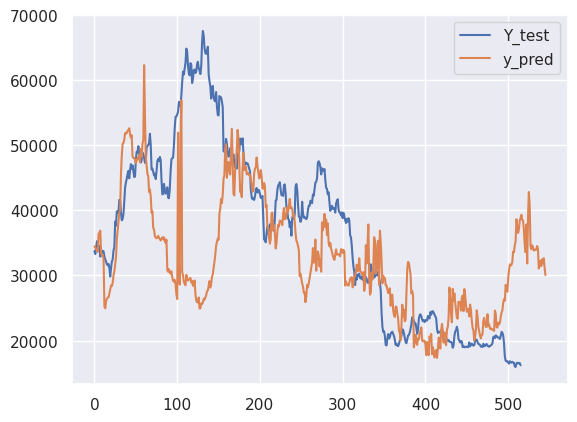

In [46]:
pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred']).plot()

In [47]:
pre_df.to_csv("../result/ANN/btc_NN.csv")

In [49]:
!kdeconnect-cli -n TAS-AN00 --ping-msg 'Script complete!'